In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Download Stock Data
stocks = ['CELH', 'CVNA', 'UPST', 'ALT', 'FUBO']  # Choose your 5 stocks
start_date = '2020-01-01'
end_date = '2024-01-01'

def get_stock_data(ticker):
    df = yf.download(ticker, start=start_date, end=end_date)
    df = df[['Close']]
    df.dropna(inplace=True)
    return df

# Collect Data
data = {stock: get_stock_data(stock) for stock in stocks}


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


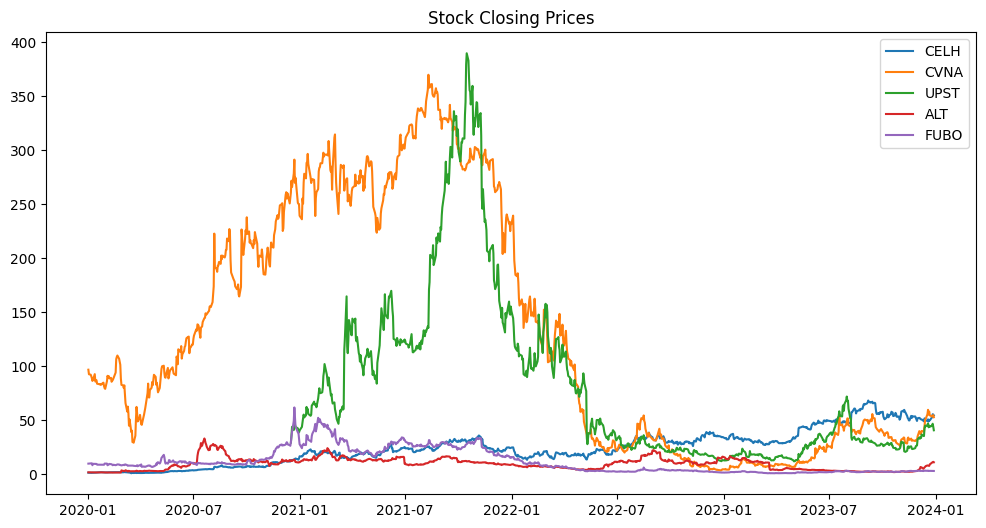

In [ ]:

# Plot Stock Prices
plt.figure(figsize=(12,6))
for stock in stocks:
    plt.plot(data[stock]['Close'], label=stock)
plt.legend()
plt.title("Stock Closing Prices")
plt.show()

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0,1))

for stock in stocks:
    data[stock]['Scaled'] = scaler.fit_transform(data[stock][['Close']])

def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 60
train_test_split = 0.8

X_train, y_train, X_test, y_test = {}, {}, {}, {}

for stock in stocks:
    stock_data = data[stock]['Scaled'].values
    X, y = create_sequences(stock_data, time_steps)
    split_idx = int(len(X) * train_test_split)
    X_train[stock], X_test[stock] = X[:split_idx], X[split_idx:]
    y_train[stock], y_test[stock] = y[:split_idx], y[split_idx:]



In [ ]:
len(X_train['CVNA']) * 60 + len(X_test['CVNA']) * 60

56760

In [ ]:
len(X_test['CVNA'])

190

Training model for CELH...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 281ms/step - loss: 0.0316 - val_loss: 0.0285
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step - loss: 0.0032 - val_loss: 0.0191
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - loss: 0.0023 - val_loss: 0.0147
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - loss: 0.0022 - val_loss: 0.0064
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 311ms/step - loss: 0.0025 - val_loss: 0.0114
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 272ms/step - loss: 0.0020 - val_loss: 0.0078
Epoch 7/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - loss: 0.0023 - val_loss: 0.0160
Epoch 8/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step - loss: 0.0019 - val_loss: 0.0120
Epoch 9/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 10/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 245ms/step - loss: 0.0020 - val_loss: 0.0128
Epoch 11/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - loss: 0.0020 - val_loss: 0.0119
Epoch 12/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/s

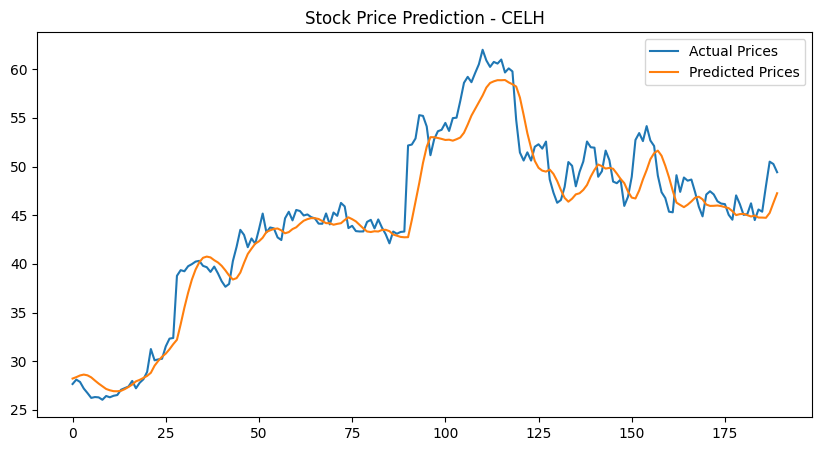

Training completed!


In [ ]:
# Build Model
def build_model():
    model = Sequential([
        Bidirectional(GRU(100, return_sequences=True), input_shape=(time_steps, 1)),
        Dropout(0.2),
        LSTM(100, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train and Evaluate
histories = {}
models = {}

for stock in stocks[0:1]:
    print(f"Training model for {stock}...")
    model = build_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train[stock], y_train[stock], validation_data=(X_test[stock], y_test[stock]),
                        epochs=40, batch_size=32, callbacks=[early_stopping], verbose=1)

    models[stock] = model
    histories[stock] = history

    # Predictions
    y_pred = model.predict(X_test[stock])

    # Rescale
    y_test_rescaled = scaler.inverse_transform(y_test[stock].reshape(-1,1))
    y_pred_rescaled = scaler.inverse_transform(y_pred)

    # Metrics
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    print(f"{stock} - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")

    # Plot Predictions
    plt.figure(figsize=(10,5))
    plt.plot(y_test_rescaled, label='Actual Prices')
    plt.plot(y_pred_rescaled, label='Predicted Prices')
    plt.legend()
    plt.title(f"Stock Price Prediction - {stock}")
    plt.show()

print("Training completed!")


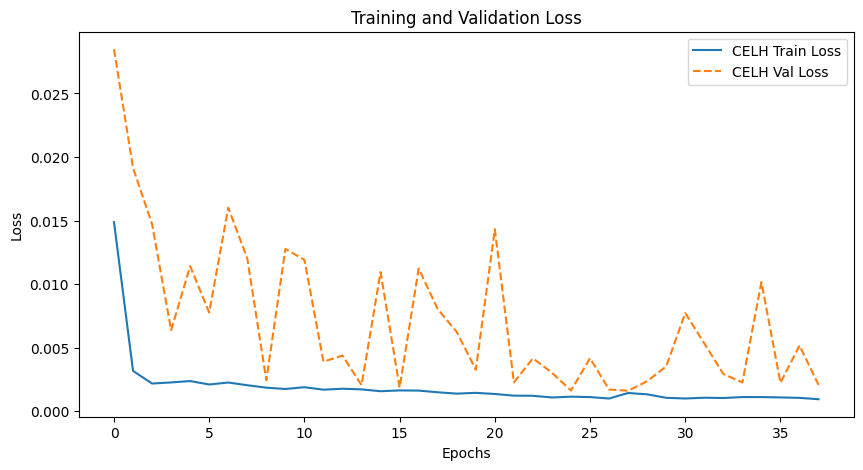

In [ ]:
plt.figure(figsize=(10,5))
for stock in stocks[0:1]:
    history = histories[stock]
    plt.plot(history.history['loss'], label=f'{stock} Train Loss')
    plt.plot(history.history['val_loss'], label=f'{stock} Val Loss', linestyle='dashed')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Carvana

In [ ]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data_source = 'alphavantage' # alphavantage or kaggle

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = 'E1BWW0VKUYSCD5O5'

    # American Airlines stock market prices
    ticker = "CVNA"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:

    # ====================== Loading Data from Kaggle ==================================
    # You will be using HP's data. Feel free to experiment with other data.
    # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')

File already exists. Loading data from CSV


In [ ]:
# Sort DataFrame by date
df = df.sort_values('Date').reset_index(drop=True)

# Double check the result
df.tail()

,Unnamed: 0,Date,Low,High,Close,Open
1961,1961,2025-02-14,272.98,286.3800,285.33,273.50
1962,1962,2025-02-18,282.81,291.2700,284.53,287.00
1963,1963,2025-02-19,280.20,292.8400,281.82,283.00
1964,1964,2025-02-20,234.24,267.6500,247.72,264.89
1965,1965,2025-02-21,223.01,247.8875,223.30,247.09


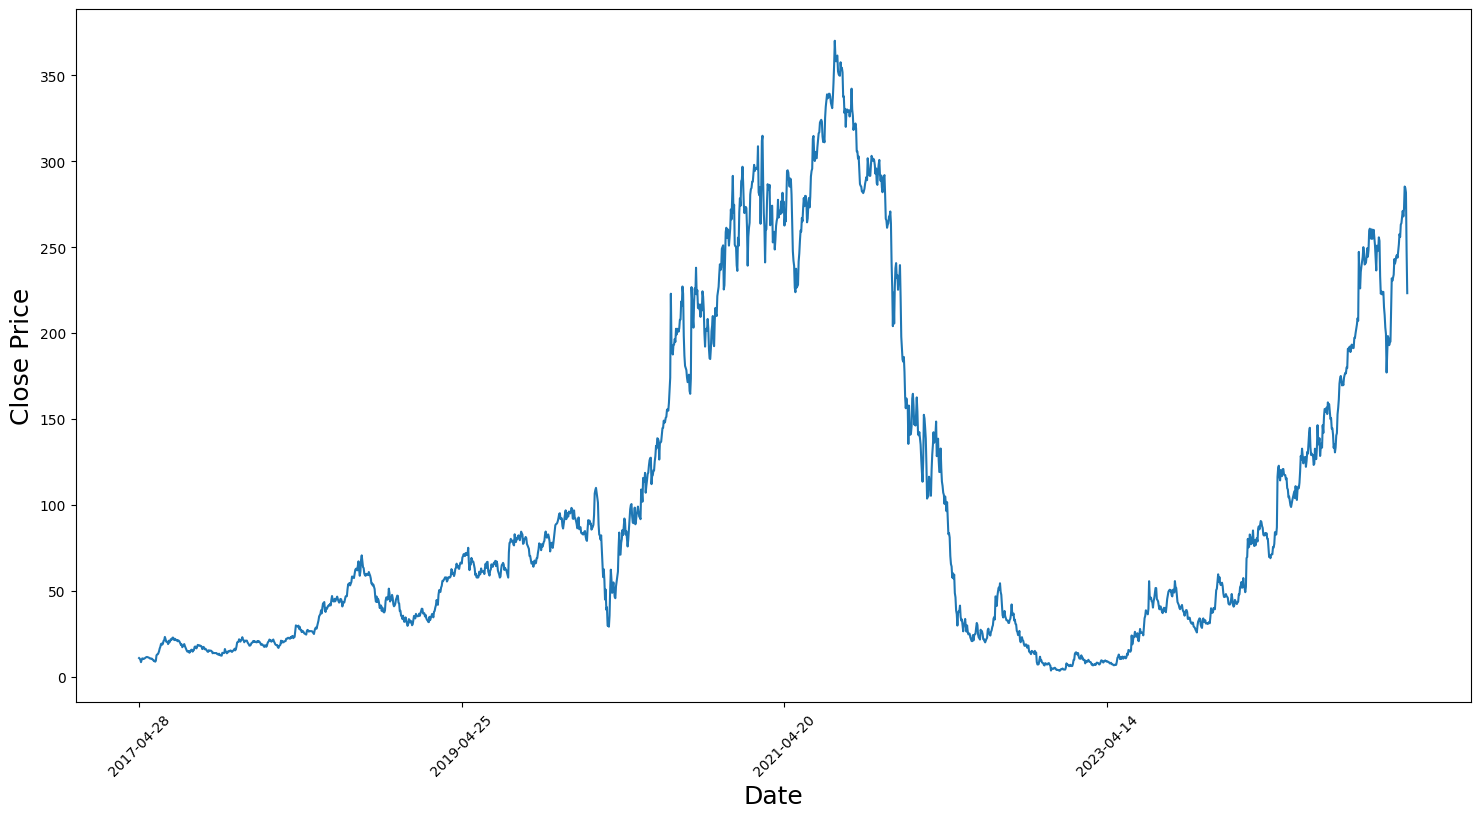

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Close']))
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

In [ ]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].apply(str_to_datetime)

In [ ]:
#Define train, valid, and test sets
train_start_date = '2020-01-01'
train_end_date = '2025-02-10'
valid_end_date = '2025-02-24'

close_price_train = df[(df['Date'] < train_end_date) & (df['Date'] > train_start_date)][['Close', 'Date']]
close_price_valid = df[df['Date'] < valid_end_date][['Close', 'Date']]
#Define train and test data
train_data = close_price_train['Close'].to_numpy()
valid_data = close_price_valid['Close'].to_numpy()

In [ ]:
#Normalize Data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

#Normalize based on windows
# Train the Scaler with training data and smooth data
# windows = 4
# smoothing_window_size = len(test_data) // windows
# for di in range(0, len(train_data), smoothing_window_size):
#     scaler.fit(train_data[di:di+smoothing_window_size,:])
#     train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

scaler.fit(train_data)
train_data_scaled = scaler.transform(train_data)

# Reshape both train and test data
train_data_scaled = train_data_scaled.reshape(-1)

In [ ]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
train_data_ema = []
for ti in range(len(train_data_scaled)):
  EMA = gamma*train_data_scaled[ti] + (1-gamma)*EMA
  train_data_ema.append(EMA)

In [ ]:
train_df = pd.DataFrame(train_data_ema, columns=['Close'])
train_df['Date'] = close_price_train['Date'].reset_index(drop=True)
train_df.index = train_df.pop('Date')
train_df

,Close
Date,
2020-01-02,0.025446
2020-01-03,0.047202
2020-01-06,0.066669
2020-01-07,0.083800
2020-01-08,0.098732
...,...
2025-02-03,0.627036
2025-02-04,0.633640
2025-02-05,0.639128


In [ ]:
import numpy as np
from datetime import timedelta

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

window = 5

windowed_df = df_to_windowed_df(train_df,
                                close_price_train.iloc[window]['Date'].strftime('%Y-%m-%d'),
                                close_price_train.iloc[len(close_price_train)-1]['Date'].strftime('%Y-%m-%d'),
                                n=window)
windowed_df

,Target Date,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2020-01-09,0.025446,0.047202,0.066669,0.083800,0.098732,0.111472
1,2020-01-10,0.047202,0.066669,0.083800,0.098732,0.111472,0.123222
2,2020-01-13,0.066669,0.083800,0.098732,0.111472,0.123222,0.135232
3,2020-01-14,0.083800,0.098732,0.111472,0.123222,0.135232,0.144172
4,2020-01-15,0.098732,0.111472,0.123222,0.135232,0.144172,0.152423
...,...,...,...,...,...,...,...
1273,2025-02-03,0.601371,0.607049,0.612324,0.616658,0.621524,0.627036
1274,2025-02-04,0.607049,0.612324,0.616658,0.621524,0.627036,0.633640
1275,2025-02-05,0.612324,0.616658,0.621524,0.627036,0.633640,0.639128
1276,2025-02-06,0.616658,0.621524,0.627036,0.633640,0.639128,0.646030


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1278,), (1278, 5, 1), (1278,))

In [ ]:
dates_train, X_train, y_train = dates, X, y

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Bidirectional(layers.GRU(units=256, return_sequences=True), input_shape=(window, 1)),
                    layers.Dropout(0.2),
                    layers.LSTM(128, return_sequences=True),
                    layers.Dropout(0.2),
                    layers.LSTM(64, return_sequences=True),
                    layers.Dropout(0.2),
                    layers.LSTM(32),
                    layers.Dropout(0.2),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - loss: 0.0640 - mean_absolute_error: 0.1690
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0033 - mean_absolute_error: 0.0378
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0028 - mean_absolute_error: 0.0342
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0027 - mean_absolute_error: 0.0337
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0023 - mean_absolute_error: 0.0327
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0022 - mean_absolute_error: 0.0306
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0021 - mean_absolute_error: 0.0308
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0023 - mean_absolute_error: 0.0308
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0023 - mean_absolute_error: 0.0316
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0022 - mean_absolute_error: 0.0297


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


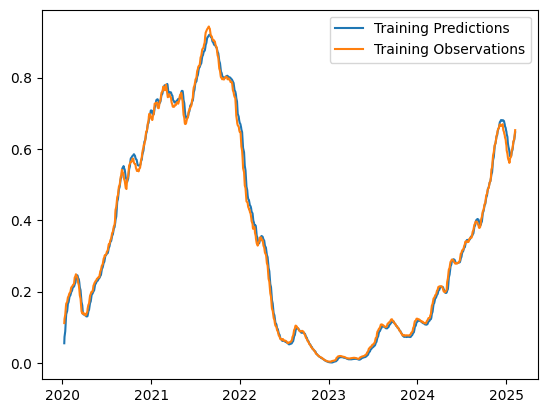

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

In [ ]:
def reverse_ema(ema_list, gamma):
  reverse_list = [ema_list[0]/0.1]
  for i in range(1, len(ema_list)):
    ema_reverse = (ema_list[i] - (1-gamma)*ema_list[i-1])/gamma
    reverse_list.append(ema_reverse)
  return reverse_list

In [ ]:
start_date = windowed_df.loc[len(windowed_df)-1, 'Target Date']
list_of_dates = list(df[df['Date'] > start_date]['Date'])
len(list_of_dates)

9

In [ ]:
predictions_df = windowed_df.copy()
for i in range(len(list_of_dates)):
  new_row = np.array([list_of_dates[i]] + list(predictions_df[-1*window:]['Target'].to_numpy(dtype=np.float32).flatten()))
  new_X = new_row[1:1+window].reshape(1,window,1).astype(np.float32)
  new_predict = model.predict(new_X).flatten()
  new_row = np.append(new_row, new_predict)
  predictions_df.loc[len(predictions_df)] = new_row
  predictions_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [ ]:
predictions_df

,Target Date,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2020-01-09,0.025446,0.047202,0.066669,0.083800,0.098732,0.111472
1,2020-01-10,0.047202,0.066669,0.083800,0.098732,0.111472,0.123222
2,2020-01-13,0.066669,0.083800,0.098732,0.111472,0.123222,0.135232
3,2020-01-14,0.083800,0.098732,0.111472,0.123222,0.135232,0.144172
4,2020-01-15,0.098732,0.111472,0.123222,0.135232,0.144172,0.152423
...,...,...,...,...,...,...,...
1282,2025-02-14,0.652487,0.652242,0.657729,0.662655,0.667198,0.671145
1283,2025-02-18,0.652242,0.657729,0.662655,0.667198,0.671145,0.674747
1284,2025-02-19,0.657729,0.662655,0.667198,0.671145,0.674747,0.679237
1285,2025-02-20,0.662655,0.667198,0.671145,0.674747,0.679237,0.683403


In [ ]:
all_ema_list = list(train_data_ema) + list(predictions_df[predictions_df['Target Date'] > start_date]['Target'])

In [ ]:
reverse_ema_list = reverse_ema(all_ema_list, 0.1)
reverse_ema_list = np.array(reverse_ema_list).reshape(-1,1)
orig_prices = scaler.inverse_transform(reverse_ema_list)

In [ ]:
valid_dates = list(predictions_df[predictions_df['Target Date'] > train_end_date]['Target Date'])

[Timestamp('2025-02-11 00:00:00'),
 Timestamp('2025-02-12 00:00:00'),
 Timestamp('2025-02-13 00:00:00'),
 Timestamp('2025-02-14 00:00:00'),
 Timestamp('2025-02-18 00:00:00'),
 Timestamp('2025-02-19 00:00:00'),
 Timestamp('2025-02-20 00:00:00'),
 Timestamp('2025-02-21 00:00:00')]

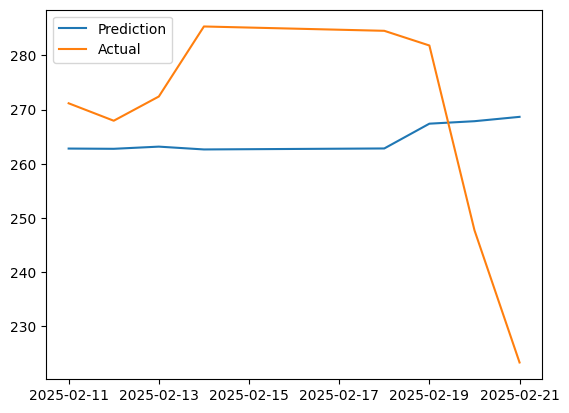

In [ ]:
plt.plot(valid_dates, orig_prices[-1*len(valid_dates):])
plt.plot(valid_dates, df[(df['Date'] >= valid_dates[0]) & (df['Date'] <= valid_dates[-1])]['Close'])
plt.legend(['Prediction', 'Actual'])